**Group names:** Michael Jakober, Cyril Winkler, Jaron Matzinger, Maurice Salzmann

For installing torchsummary use `pip install torchsummary`

In [1]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt

## Multinomial Classification of MNIST 

1. Load the MNIST dataset by clicking through the first cells and see how to depict some samples. Please note that a training and a test dataset are loaded. Make sure that only the training set will be used for training and the test dataset just for evaluation (accuracy). 
2. Implement the multinomial logistic regression model by completing the code in the functions \verb|linear_trsf|, \verb|softmax|, \verb|predict|, \verb|loss_ce|, \verb|cost_ce|. 
3. Implement the mini-batch gradient descent training loop configured by number of epochs, batch size and learning rate. Implement the gradient explicitly (without autograd). Train the model with \verb|nepochs=10|, \verb|nbatch=64| and \verb|lr=0.01|. 
4. Tune learning rate and batch size and qualitatively characterise the behaviour. What is your favorite combination (learning rate, batch size, number of epochs)
5. Build and train the model with full-fledge pytorch incl. autograd. Implement a model class inheriting from $torch.nn.Module$ and use the layer functionality in the package $torch.nn$ (see lecture). Prove that you obtain the same accuracy.


#### Hints 
* Keep an eye on the shapes of the tensors (as passed into the functions and as used within the functions (and declared in the function descriptions).
* For each implemented function, run a small test with dummy input tensors (of the required shape) and check whether it outputs a tensor with expected shape and no 'nan'.
* Possibly, add \verb|assert()| statements in the code.
* For the training loop perform a training with only a single batch of size 64. Here, you should be able to obtain 100% training accuracy.

### 1. Loading the Data

Click through the cells below to load the MNIST dataset and learn how to access its samples.

#### Dataset

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [5]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [6]:
print(len(training_data))
x, y = training_data[5]
print(type(x), x.shape, x.dtype)
print(type(y), y)

60000
<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32
<class 'int'> 2


#### Depict samples

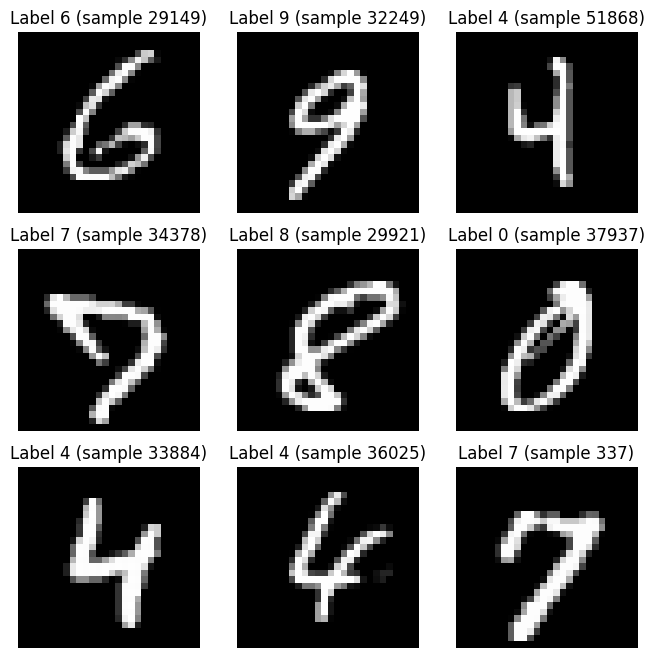

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)"%(label,sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader (see lecture)

In [8]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [9]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


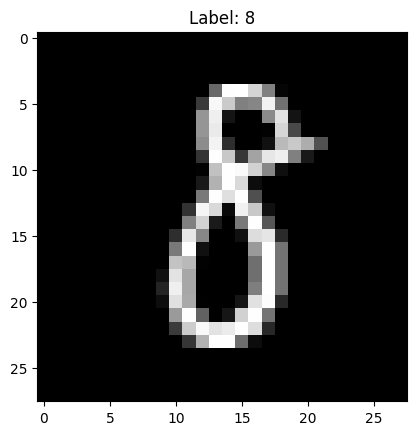

In [10]:
img = data_train[0].squeeze()
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### 2. Multinomial Logistic Regression

Now, implement the model, i.e. multinomial logistic regression and the loss/cost function (cross-entropy cost).

To that end, implement the python functions below. 
All arguments are pytorch tensors with indicated shapes.

In [11]:
def linear_trsf(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    nb = x.shape[0]
    x1 = x.view(nb, -1)
    return x1 @ W.T + b
    # YOUR CODE (END)

def softmax(z):
    """
    z -- tensor of shape (nb,10)
    """
    # YOUR CODE (START)
    s = torch.exp(z)
    return s / torch.sum(s, dim=1, keepdim=True)
    # YOUR CODE (END)
    
def predict(x,W,b):
    """
    x -- tensor with shape (nb,1,28,28)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (1,10)
    """
    # YOUR CODE (START)
    trsf = linear_trsf(x,W,b)
    return softmax(trsf)
    
    # YOUR CODE (END)


##### TEST

In [12]:
W,b = torch.randn((10,28*28)), torch.zeros((1,10))
print(W.shape,b.shape)
u = predict(x,W,b)
print(u.shape, torch.sum(u).item())

torch.Size([10, 784]) torch.Size([1, 10])
torch.Size([1, 10]) 1.0


#### Loss Function

In [13]:
def loss_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    returns -- per sample loss 
    """
    # YOUR CODE (START)
    nb = y.shape[0]
    return -torch.log(uhat[torch.arange(nb),y[:]])
    # YOUR CODE (END)

def cost_ce(y,uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    return -- per batch mean of losses
    """
    # YOUR CODE (START)    
    return torch.mean(loss_ce(y, uhat))
    
    # YOUR CODE (END)


##### TEST

In [14]:
import numpy as np
y = torch.tensor([0,2])
z = torch.tensor([[1.,2,3],[2,2,2]]).reshape(-1,3)
uhat = softmax(z)
print(loss_ce(y,uhat), cost_ce(y,uhat))

tensor([2.4076, 1.0986]) tensor(1.7531)


### 3. Mini-Batch Gradient Descent

For the training, we adopt gradient descent - and start with the implementation of the gradient of the cost function (cross-entropy cost function).  

#### Gradient

In [16]:
def grad_loss_ce(x,u,uhat):
    """
    x -- tensor with shape (nb,1, 28*28)
    u -- tensor with shape (nb,10)
    uhat -- tensor with shape (nb,10)
    returns -- gradW, gradb (same dimension as W and b)
    """
    # YOUR CODE (START)
    gradW = torch.mean((uhat - u).view(-1, 10, 1) * x.view(-1, 1, 28*28), dim=0)
    gradb = torch.mean((uhat - u), dim=0)
    return gradW, gradb
    
    # YOUR CODE (END)

#### Metrics - Cost, Accuracy

For tracking the progress of the training, we will use two functions: the cost and the accuracy. 

In [17]:
def metrics(X,Y,W,b):
    """
    X -- tensor with shape (nb,1,28*28)
    Y -- tensor with shape (nb,10)
    W -- tensor with shape (10,28*28)
    b -- tensor with shape (10,1)

    return -- cost, acc (both scalars)
    """
    # YOUR CODE (START)
    u_hat = predict(X,W,b)
    cost = cost_ce(Y, u_hat)

    y_pred = torch.argmax(u_hat, dim=1)
    acc = (y_pred == Y).float().mean()

    return cost, acc
    # YOUR CODE (END)

#### Training

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [21]:
nepochs = 10
alpha = 0.01
nclasses = 10
nbatch = 64
num_batches = len(training_data)/float(nbatch)

cost_hist = []
acc_hist = []
cost_hist_test = []
acc_hist_test = []

# data loader
train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)

# test data - we can load all samples for the test since it easily fits into memory
Xtest,Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True))) 

# initial parameters
W,b = torch.randn((10,28*28)), torch.zeros((1,10))

d0 = datetime.now()

for epoch in range(nepochs):
    cost = 0.0
    acc = 0
    for X,Y in train_dataloader:
        u_hat = predict(X,W,b)
        u = (Y.view(-1, 1) == torch.arange(nclasses).view(1, nclasses)).float()   

        gradW, gradb = grad_loss_ce(X, u, u_hat)

        W = W - alpha*gradW
        b = b - alpha*gradb

    cost, acc = metrics(X, Y, W, b)
    cost_hist.append(cost)
    acc_hist.append(acc)

    with torch.no_grad():
        cost_test, acc_test = metrics(Xtest, Ytest, W, b)
        cost_hist_test.append(cost_test)
        acc_hist_test.append(acc_test)
        
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    
d = datetime.now()
print((d-d0).total_seconds()/nepochs)  

Epoch 0: 3.977730, 0.375000, 3.930936, 0.424100
Epoch 1: 1.952659, 0.718750, 2.484693, 0.580000
Epoch 2: 1.869260, 0.656250, 1.906278, 0.654100
Epoch 3: 2.716859, 0.468750, 1.593277, 0.698300
Epoch 4: 1.787010, 0.750000, 1.392598, 0.729800
Epoch 5: 1.169523, 0.656250, 1.257434, 0.753000
Epoch 6: 0.883347, 0.781250, 1.158799, 0.769300
Epoch 7: 0.916733, 0.875000, 1.082606, 0.781300
Epoch 8: 0.124297, 0.968750, 1.020959, 0.791300
Epoch 9: 1.277130, 0.812500, 0.971824, 0.800900
19.0856438


Text(0.5, 1.0, 'Accuracy')

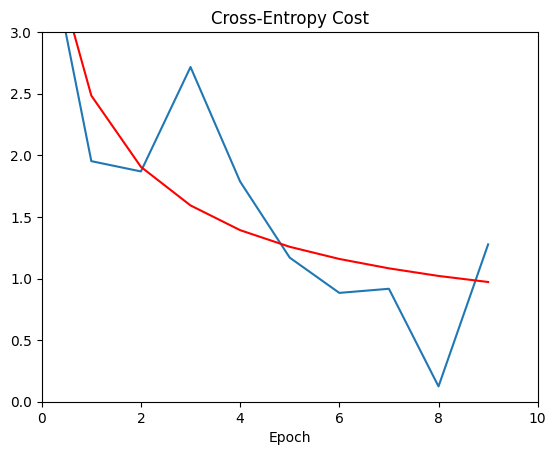

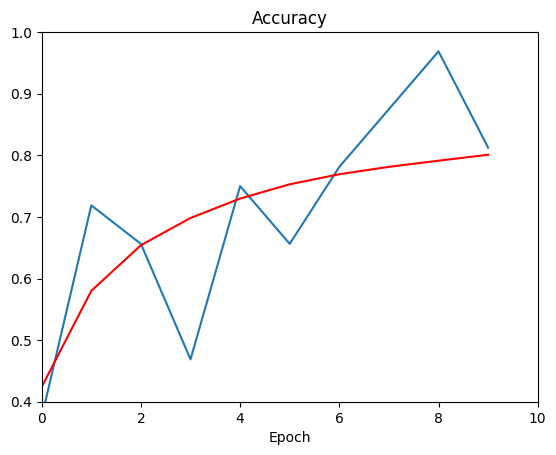

In [22]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,3)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.4,1)
plt.title("Accuracy")

### 4. Tune learning rate and batch size

Now analyse the training progress with five, well selected settings for each, the learning rate and the batch size.
Make sure that for each setting, a more or less "stable" test performance is achieved, i.e. a status where the test accurace is no longer expected to improve. Choose the number of epochs accordingly.

Finally, prepare suitable plots and tables to make the comparison transparent and characterize in words what you observe. 

Explain the behavior.

In [28]:
nepochs = 10
nclasses = 10

# test data - we can load all samples for the test since it easily fits into memory
Xtest, Ytest = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True))) 

Xtest = Xtest.to(device)
Ytest = Ytest.to(device)

accuracies = []
alphas = []
nbatches = []

for alpha in [1, 0.1, 0.01, 0.001, 0.0001]:
    for nbatch in [32, 64, 128, 256, 512]:
        print(f"Run with alpha {alpha} and batch-size {nbatch}")
        num_batches = len(training_data)/float(nbatch)
        
        cost_hist = []
        acc_hist = []
        cost_hist_test = []
        acc_hist_test = []
        
        # data loader
        train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
        
        # initial parameters
        W,b = torch.randn((10,28*28)).to(device), torch.zeros((1,10)).to(device)
        
        d0 = datetime.now()
        
        for epoch in range(nepochs):
            cost = 0.0
            acc = 0
            for X,Y in train_dataloader:
                X = X.to(device)
                Y = Y.to(device)
                u_hat = predict(X,W,b)
                u = (Y.view(-1, 1) == torch.arange(nclasses).view(1, nclasses).to(device)).float()   
        
                gradW, gradb = grad_loss_ce(X, u, u_hat)
        
                W = W - alpha*gradW
                b = b - alpha*gradb
        
            cost, acc = metrics(X, Y, W, b)
            cost_hist.append(cost)
            acc_hist.append(acc)
        
            with torch.no_grad():
                cost_test, acc_test = metrics(Xtest, Ytest, W, b)
                cost_hist_test.append(cost_test)
                acc_hist_test.append(acc_test)
                
            print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
            
        d = datetime.now()
        print((d-d0).total_seconds()/nepochs)
        accuracies.append(max(acc_hist_test))
        alphas.append(alpha)
        nbatches.append(nbatch)

Run with alpha 1 and batch-size 32
Epoch 0: 0.071034, 1.000000, 0.486361, 0.898800
Epoch 1: 0.014686, 1.000000, 0.430226, 0.905300
Epoch 2: 0.064167, 1.000000, 0.434859, 0.905400
Epoch 3: 0.129680, 0.968750, 0.414271, 0.905500
Epoch 4: 0.136701, 0.937500, 0.440308, 0.900200
Epoch 5: 0.075833, 1.000000, 0.557407, 0.871800
Epoch 6: 0.027168, 1.000000, 0.379925, 0.911500
Epoch 7: 0.036812, 1.000000, 0.461320, 0.895800
Epoch 8: 0.165441, 0.906250, 0.383438, 0.913300
Epoch 9: 0.070387, 1.000000, 0.383660, 0.907900
8.5519228
Run with alpha 1 and batch-size 64
Epoch 0: 0.390328, 0.937500, 0.510163, 0.884900
Epoch 1: 0.747812, 0.812500, 0.571577, 0.862700
Epoch 2: 0.504662, 0.968750, 0.472915, 0.886200
Epoch 3: 0.055971, 1.000000, 0.374922, 0.909000
Epoch 4: 0.097929, 0.968750, 0.497206, 0.873400
Epoch 5: 0.050917, 1.000000, 0.359544, 0.909200
Epoch 6: 0.124129, 0.937500, 0.380243, 0.903600
Epoch 7: 0.124465, 0.968750, 0.370089, 0.899800
Epoch 8: 0.199514, 0.937500, 0.519306, 0.862900
Epoch 9:

Text(0.5, 1.0, 'Accuracy')

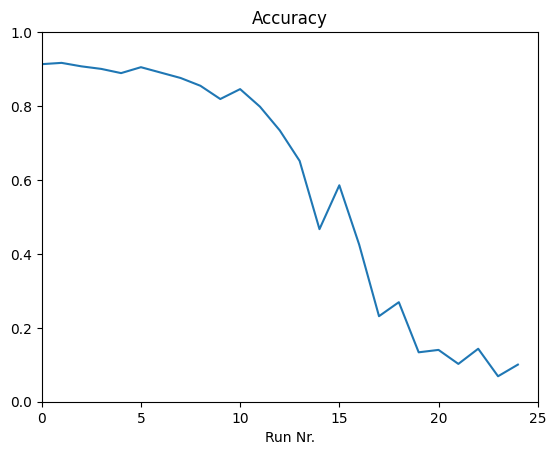

In [30]:
plt.plot(torch.arange(len(accuracies)), [acc.cpu() for acc in accuracies], "-")
plt.xlabel("Run Nr.")
plt.xlim(0, 25)
plt.ylim(0,1)
plt.title("Accuracy")

In [32]:
best_run = torch.argmax(torch.tensor(accuracies))
best_acc = accuracies[best_run]
best_alpha = alphas[best_run]
best_nbatch = nbatches[best_run]

print(f"Best Accuracy: {best_acc}, Best Alpha {best_alpha}, Best batch-size {best_nbatch}")

Best Accuracy: 0.9167999625205994, Best Alpha 1, Best batch-size 64


**Answer:** Small Batch-Sizes leads to a training accuracy of 100%, but does not really reflect in the testset. Smaller Learning-Rates lead to a smoother approach of the best result, however they take longer to reach an optimum and do not reach that inside the 10 epochs. In this case, Learning-Rate of 1 is the best with a batchsize of 64.

### 5. With Full-Fledge PyTorch

In [ ]:
class NeuralNetwork(torch.nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear  = torch.nn.Linear(28*28, 10)
    
    def forward(self, x): # use just one linear layer and pytorch's CrossEntropyLoss
        z = self.linear(self.flatten(x))
        return z


In [ ]:
model = NeuralNetwork()
print(model)

In [ ]:
summary(model, (1,28,28))

In [ ]:
nbatch = 64
nepochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

cost_ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
Xtest, Ytest = next(iter(test_loader))
size = len(training_loader.dataset)
size_test = len(test_loader.dataset)
nbatches = len(training_loader)
nbatches_test = len(test_loader)

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        pred = model(X)
        loss = cost_ce(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cost += loss.item()
        acc += (pred.argmax(dim=1) == Y).float().sum().item()

    cost /= nbatches
    acc /= size

    cost_test = 0.0
    acc_test = 0.0

    with torch.no_grad():
        for X, Y in test_loader:
            pred = model(X)
            loss = cost_ce(pred, Y)
            cost_test += loss.item()
            acc_test += (pred.argmax(dim=1) == Y).float().sum().item()
    
    cost_test /= nbatches_test
    acc_test /= size_test
    
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


In [ ]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0.8,1)
plt.title("Accuracy")